# **A/B Тест**

In [49]:
# from google.colab import files

# upload = files.upload()

In [50]:
!pip install --upgrade statsmodels

## **EDA**

In [51]:
import pandas as pd

df = pd.read_csv('Cookie_Cats_cleaned_v01.csv')

# Выведем первые пять строк датасета
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Посмотрим на информацию о датасете.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Можем заметить, что у нас нет пропущенных значений.

Посмотрим, есть ли дубликаты в датасете.

In [53]:
df.duplicated(subset=['userid']).sum()

np.int64(0)

Дубликатов не обнаружено.

Рассмотрим описательную информацию числовых метрик в датасете.

In [54]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


**Количество наблюдений** - 90189,

**Среднее** - 51.87,

**Стандартное отклонение** - 195,

**Минимальное значение** - 0,

**Значение, ниже которого находится 25% пользователей (Первый квартиль)** - 5,

**Значение, ниже которого находится 50% пользователей (Медиана)** - 16,

**Значение, ниже которого находится 75% пользователей (Третий квартиль)** - 51,

**Максимальное значение** - 49854.

Из этого понятно, что данные имеют сильное разнообразие активностей, т.к. данные имеют высокое стандартное отклонение: большинство пользователей сыграли в среднем 51 раунд, однако присутствуют пользователи, которые сыграли аномальное большое количество раундов - 50000.

Из-за низкой медианы и первого квартиля, можно сделать вывод, что данные скошены влево. Большинство пользователей играют не так много, что подтверждается также минимальным значением данного показателя - 0.

Также данные содержат в себе некоторое количество пользователей, которые сыграли в игру огромное количество раундов, что можно считать аномалием/выбросом, которое нужно правильно обработать в будущем.

In [55]:
df['version'].value_counts(normalize=True) * 100

,proportion
version,
gate_40,50.437415
gate_30,49.562585


Видим, что количество наблюдений в группах **равны**.

### **Анализ распределений**

Посмотрим на гистограмму и boxplot **числовых признаков**:

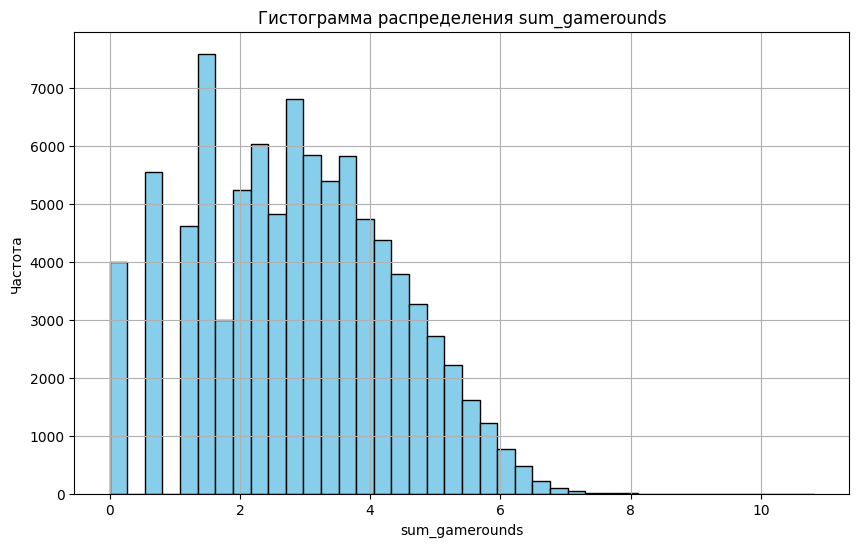

In [56]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
# Воспользуемся логорифимическим преобразованием дабы уменьшить влияние выбросов и больших значений
plt.hist(np.log1p(df['sum_gamerounds']), bins=40, color='skyblue', edgecolor='black')
plt.title('Гистограмма распределения sum_gamerounds')
plt.xlabel('sum_gamerounds')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Видим, что гистограмма имеет правый хвост, большая часть данных сосредоточена в левой части графика. Большинство пользователей сыграло малое количество раундов.

Частота пользователей постепенно уменьшается с увеличением количества раундов.

С увеличением количества раундов, распределение пользователей напоминает нормальное с плоским хвостом на правой стороне. Это означает, что в выборке есть пользователи с высокой активностью, но они не составляют значительную часть данных.


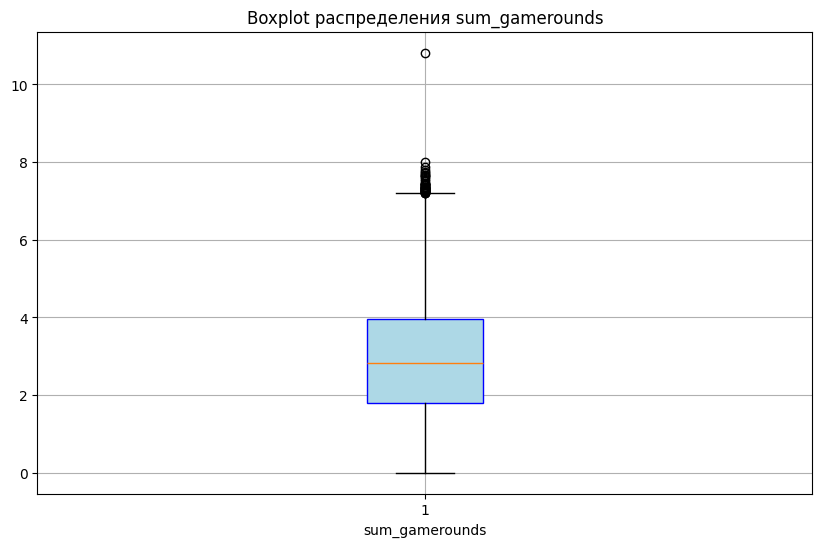

In [57]:
plt.figure(figsize=(10, 6))
# Воспользуемся логорифимическим преобразованием дабы уменьшить влияние выбросов и больших значений
plt.boxplot(np.log1p(df['sum_gamerounds']), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'))
plt.title('Boxplot распределения sum_gamerounds')
plt.xlabel('sum_gamerounds')
plt.grid(True)

По графику можем опять увидеть, что вся область от первого до третьего квартиля лежит в диапазоне от 2 до 4, что означает, что большинство пользователей сыграло малое количество раундов.

Разница между первым и третьим квартилем показывает, что межквартильный размах (IQR) не слишком велик, что свидетельствует о том, что данные относительно концентрированы в этом диапазоне, и отклонений от среднего значения не так много.

Выбросы подтверждаются черными точками выше верхнего уса. В данных присутствуют пользователи с очень высокой активностью, которые сильно отличаются от основной массы пользователей.



Посмотрим, как распределены **категориальные признаки**:

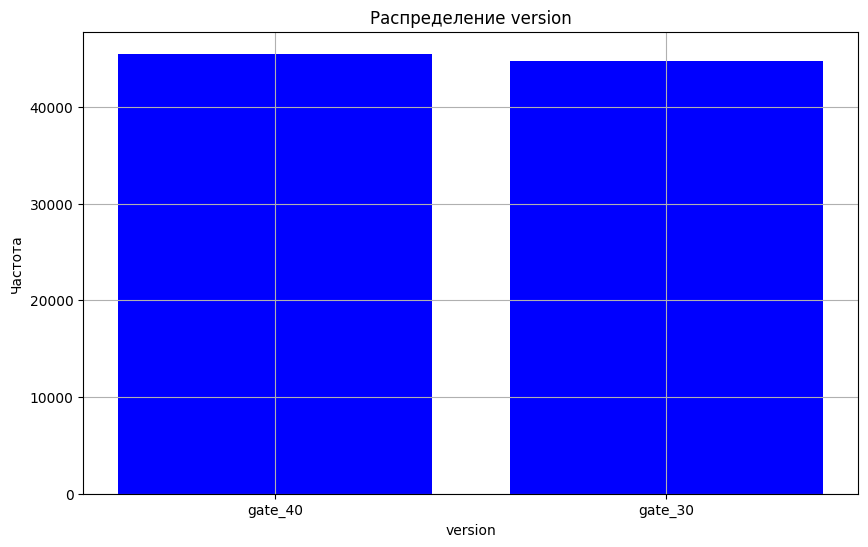

In [58]:
plt.figure(figsize=(10, 6))
plt.bar(df['version'].value_counts().index, df['version'].value_counts(), color='blue')
plt.title('Распределение version')
plt.xlabel('version')
plt.ylabel('Частота')
plt.grid(True)

Видим, что частоты двух групп распределены практически **равномерно**.

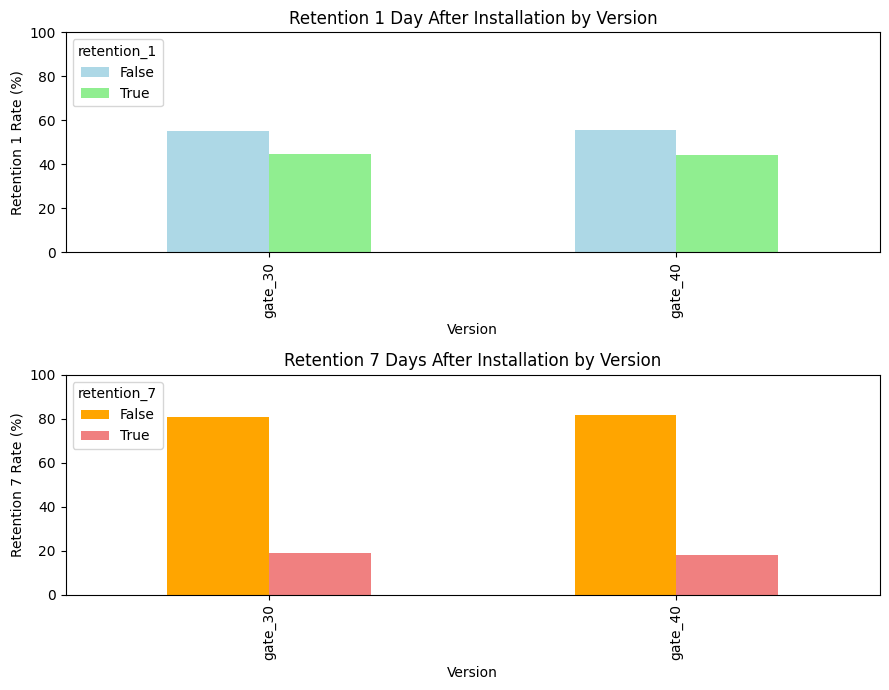

In [59]:
# Рассчитываем процентное распределение для 'retention_1' по версиям
retention_1_by_version = df.groupby(['version', 'retention_1']).size().unstack(fill_value=0)
retention_1_by_version = retention_1_by_version.div(retention_1_by_version.sum(axis=1), axis=0) * 100

# Рассчитываем процентное распределение для 'retention_7' по версиям
retention_7_by_version = df.groupby(['version', 'retention_7']).size().unstack(fill_value=0)
retention_7_by_version = retention_7_by_version.div(retention_7_by_version.sum(axis=1), axis=0) * 100

# Создаем подграфики для retention_1 и retention_7
fig, axes = plt.subplots(2, 1, figsize=(9, 7))

# График для retention_1
retention_1_by_version.plot(kind='bar', stacked=False, ax=axes[0], color=['lightblue', 'lightgreen'])
axes[0].set_title('Retention 1 Day After Installation by Version')
axes[0].set_ylabel('Retention 1 Rate (%)')
axes[0].set_xlabel('Version')
axes[0].set_ylim(0, 100)
axes[0].legend(title='retention_1', loc='upper left', labels=['False', 'True'])

# График для retention_7
retention_7_by_version.plot(kind='bar', stacked=False, ax=axes[1], color=['orange', 'lightcoral'])
axes[1].set_title('Retention 7 Days After Installation by Version')
axes[1].set_ylabel('Retention 7 Rate (%)')
axes[1].set_xlabel('Version')
axes[1].set_ylim(0, 100)
axes[1].legend(title='retention_7', loc='upper left', labels=['False', 'True'])

# Настроим отображение
plt.tight_layout()
plt.show()

Как можем заметить на графике №1, что количество людей, не вернувшиеся после 1 дня составляет более 50% в двух группах.
Для обеих групп gate_30 и gate_40 видно небольшое отличие в уровне удержания пользователей.

На графике №2 можем увидеть почти похожую ситуацию, однако уровень не вернувшихся клиентов вырос и составляет в районе 80% в обеих группах. Для gate_30 и gate_40 также наблюдается небольшая разница в уровне удержания пользователей.

### **Вывод после проведения EDA**

1. Распределение количества сыгранных раундов ненормальное. Гистограмма показывает, что основная масса пользователей провела небольшое количество времени в игре, что свидетельствует о том, что большинство пользователей имеют низкий уровень активности. Это также подтверждается положительным скосом распределения, где данные сосредоточены в левой части, а хвост тянется вправо, указывая на наличие пользователей с аномально большим количеством сыгранных раундов. Эти аномальные наблюдения (выбросы) могут сильно влиять на статистические результаты, и для корректного анализа данных важно учесть их наличие, возможно, применяя методы для обработки выбросов или проведения анализа без учета таких значений.

2. Уровень удержимости пользователей игры также желает лучшего. Было выяснено, что уровень удержимости пользователей после 1 дня составляет около 50% в обеих группах. Уровень удержимости после 7 дня показывает нам значение в 80% в обеих группах. Также количество наблюдений в группах примерно одинаковое, что поможет нам в проведении A/B теста, т.к. результаты будут объективными и неискажёнными.

## **Обработка данных**

Так как в наших данных есть аномальные выбросы, то нужно их должным образом обработать. Для этого я воспользуюсь методом IQR (Interquartile Range) для удаления выбросов.

**IQR** - разница между 75-ым и 25-ым перцентилем данных:

**IQR = Q3-Q1**

Далее выбросами считаются значения, которые будут лежать за пределами следующего диапазона:

**Нижняя граница** = Q1 - 1.5 * IQR

**Верхняя граница** = Q3 + 1.5 * IQR

Данные, которые лежат за пределами данного интервала могут быть **удалены**.


In [60]:
def remove_outliers_iqr(df):
  Q1 = df['sum_gamerounds'].quantile(0.25)
  Q3 = df['sum_gamerounds'].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df['sum_gamerounds'] >= lower_bound) & (df['sum_gamerounds'] <= upper_bound)]
  return df

Как мы видим, осталось порядка 80000 наблюдений (изначально их было порядка 90000).

In [61]:
control_group_before_iqr = df[df['version'] == 'gate_30']
test_group_before_iqr = df[df['version'] == 'gate_40']

controlled_group = remove_outliers_iqr(control_group_before_iqr)
test_group = remove_outliers_iqr(test_group_before_iqr)

print(controlled_group.info())
print('_____________________________________________________________')
print(test_group.info())

<class 'pandas.core.frame.DataFrame'>
Index: 39493 entries, 0 to 90186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          39493 non-null  int64 
 1   version         39493 non-null  object
 2   sum_gamerounds  39493 non-null  int64 
 3   retention_1     39493 non-null  bool  
 4   retention_7     39493 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.3+ MB
None
_____________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Index: 40471 entries, 3 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          40471 non-null  int64 
 1   version         40471 non-null  object
 2   sum_gamerounds  40471 non-null  int64 
 3   retention_1     40471 non-null  bool  
 4   retention_7     40471 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1

Как мы можем увидеть, после обработки количество наблюдений в каждой из групп остаётся примерно одинаковым.

## **Определение размера выборок**

Определим теперь уровень удержимости пользоваетелей контрольных групп:

In [62]:
print('Для retention_1')
print()
print('Контрольная группа')
print(controlled_group['retention_1'].value_counts(normalize=True))

print('Для retention_7')
print()
print('Контрольная группа')
print(controlled_group['retention_7'].value_counts(normalize=True))

print('Для sum_gamerounds')
print()
print('Контрольная группа')
print("Среднее значение:", + controlled_group['sum_gamerounds'].mean())

Для retention_1

Контрольная группа
retention_1
False    0.612564
True     0.387436
Name: proportion, dtype: float64
Для retention_7

Контрольная группа
retention_7
False    0.883473
True     0.116527
Name: proportion, dtype: float64
Для sum_gamerounds

Контрольная группа
Среднее значение: 23.59653609500418


Видим, что для контрольной группы уровень удержания клиентов после первого дня составляет - **0.38**

Для контрольной группы удержание клиентов после седьмого дня составляешь - **0.11**

Определим следующие переменные:

 **Уровень значимости (alpha**) = 0.05 (для 95% доверительного интервала),

**Вероятность ошибки II рода (beta)** = 0.2,

**Мощность теста (1-beta)** = 0.8.

Для того, чтобы определить нужный размер выборок, воспользуемся функцией statsmodels.stats.power.NormalIndPower для бинарных метрик (retention_1 и retention_7) и statsmodels.stats.power.TTestIndPower для непрерывных метрик (sum_gamerounds).

Вычислим размеры выборок для нашего теста:



In [63]:
import scipy.stats as stats
import statsmodels.stats.api as sms

alpha = 0.05
beta = 0.2
power = 1 - beta

p1_retention1 = 0.39  # контрольная группа
p2_retention1 = 0.44  # тестовая группа

# Расчет размера выборки
effect_size_retention_1 = sms.proportion_effectsize(p1_retention1, p2_retention1)
n_retention_1 = sms.NormalIndPower().solve_power(effect_size=effect_size_retention_1, power=power, alpha=alpha, ratio=1)
print(n_retention_1)

1522.979768515092


Получили результат - **1522**. Это и есть размер групп для нашей метрики retentnio_1.

Для retention_7 у нас следующие показатели:

**p1** = 0.11

Мы хотим повысить удержимость на 5%, следовательно

**p2** = 0.16

Вычислим размеры выборок для данной метрики:

In [64]:
p1_retention7 = 0.11  # контрольная группа
p2_retention7 = 0.16  # тестовая группа

# Расчет размера выборки
effect_size_retention_7 = sms.proportion_effectsize(p1_retention7, p2_retention7)
n_retention_7 = sms.NormalIndPower().solve_power(effect_size=effect_size_retention_7, power=power, alpha=alpha, ratio=1)
print(n_retention_7)

727.4015082510675


Получили результат - **727**. Это и есть размер групп для метрики retention_7.

Для Sum_gamerounds у нас следующие показатели:

**mean_control** = 24

Мы хотим повысить среднее количество сыгранных раундов на 5, следовательно

**mean_test** = 29

Вычислим размеры выборок для данной метрики:



In [65]:
from statsmodels.stats.power import TTestIndPower

mu1 = controlled_group['sum_gamerounds'].mean()
mu2 = mu1 + 5
delta = 5

sigma = controlled_group['sum_gamerounds'].std()

effect_size = delta / sigma
n = TTestIndPower().solve_power(effect_size=effect_size, power=0.8, alpha=0.05)

print(n)

444.72833018479855


Получили результат - **444**. Это и есть размер групп для метрики sum_gamerounds.

**Для проведения A/B теста мы выберем самый максимальный размер для наших выборок - 1522. Мы выбираем размер, достаточный для самой требовательной метрики (retention_1), чтобы обеспечить мощность 80% по всем гипотезам. Затем отберем рандомно 1522 наблюдений для тестовой и контрольной групп, а затем используя эти группы проведем A/B тест для всех наших метрик.**

In [66]:
controlled_group = controlled_group.sample(n=1522, random_state=42) # отбираем рандомно 1522 наблюдения
test_group = test_group.sample(n=1522, random_state=42)

## **Проведение бинарного A/B теста для retention_1 и retention_7**

**Задача:** Проверить, увеличился ли ретеншн на 5% через 1 день в тестовой группе по сравнению с контрольной группой. Для этого мы будем использовать Z-тест для пропорций.

**Гипотеза:**

**H0:** Разница в пропорциях равна 0 (нет существенного увеличения уровня удержимости пользователей).

**H1:** Разница в пропорциях больше 0.

**Шаги:**

1. Пользователи в обеих группах должны быть **независимы**.
2. Для Z-теста необходимо, чтобы соблюдались следующие условия:

**np > 5**, **n(1-p) > 5**

где n - размер выборки, а p - пропорция успеха (например, соотношение пользователей, которые вернулись в игру после первого дня).

3. Вычислить наблюдаемые пропорции ретеншн в обеих группах.
4. Выполнение Z-теста для пропорций.
5. Определяем статистическую значимость.
6. Делаем выводы.

In [67]:
from statsmodels.stats.proportion import proportions_ztest

# Среднее значение для каждой группы
p_control = controlled_group['retention_1'].mean()
p_test = test_group['retention_1'].mean()
# Количество наблюдений в каждой группе
n_control = 1522
n_test = 1522

assumption = True
## Проверка условий для Z-теста
if n_control * p_control <= 5:
  print("Условие не выполнено. n * p должно быть больше 5")
  assumption = False
if n_control * (1 - p_control) <= 5:
  print("Условие не выполнено. n * (1 - p) должно быть больше 5")
  assumption = False
if n_test * p_test <= 5:
  print("Условие не выполнено. n * p должно быть больше 5")
  assumption = False
if n_test * (1 - p_test) <= 5:
  print("Условие не выполнено. n * (1 - p) должно быть больше 5")
  assumption = False

if assumption:
  print("Условия для Z-теста выполнены")

  success_retention_1 = [controlled_group['retention_1'].sum(), test_group['retention_1'].sum()]
  total_retention_1 = [n_control, n_test]

  z_stat_retention_1, p_value_retention_1 = proportions_ztest(success_retention_1, total_retention_1, value=0, alternative='larger')

  print("Z-статистика:", z_stat_retention_1)
  print("p-значение:", p_value_retention_1)

  if p_value_retention_1 < alpha:
    print("Разница в пропорциях статистически значима.")
  else:
    print("Разница в пропорциях не является статистически значимой.")


Условия для Z-теста выполнены
Z-статистика: -1.1919432383831536
p-значение: 0.8833582487065378
Разница в пропорциях не является статистически значимой.



**Результаты Z-теста для сравнения пропорций retention_1**

- **Z-статистика**: -1.19
- **p-значение**: 0.88
- **Уровень значимости (α)**: 0.05 (стандартное значение)

Поскольку **p-значение (0.88)** **значительно превышает** порог значимости **0.05**, мы **не можем отвергнуть нулевую гипотезу (H₀)**.

Это означает, что:
> **Разница в долях (пропорциях) между группами статистически не значима.**

Наблюдаемое различие может быть объяснено **случайной вариацией**, а не реальным эффектом.

**Построим также доверительный интервал (ДИ) для разницы в пропорциях нашей метрики**:


In [68]:
import numpy as np
from scipy.stats import norm

# retention_1
x1 = controlled_group['retention_1'].sum()
n1 = len(controlled_group)

x2 = test_group['retention_1'].sum()
n2 = len(test_group)

p1 = x1 / n1
p2 = x2 / n2
diff = p2 - p1

# Стандартная ошибка разницы пропорций
se = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

# z-критическое значение для 95% CI
z = norm.ppf(0.975)  # = 1.96

# Доверительный интервал
margin = z * se
ci_low = diff - margin
ci_upp = diff + margin

print(f"Retention_1:")
print(f"  Разница (test - control): {diff:.4f}")
print(f"  95% ДИ: [{ci_low:.4f}, {ci_upp:.4f}]")
print(f"  p1 = {p1:.4f}, p2 = {p2:.4f}")

Retention_1:
  Разница (test - control): 0.0210
  95% ДИ: [-0.0135, 0.0556]
  p1 = 0.3745, p2 = 0.3955





- **Разница (test - control)**: +0.0210 → тестовая группа на **2.1 п.п.** выше, чем контрольная.
- **95% ДИ**: `[-0.0135, 0.0556]`
- **p1 = 0.3745** → доля удержания в контрольной группе
- **p2 = 0.3955** → доля удержания в тестовой группе

1. **Доверительный интервал включает 0**  
   Это означает, что **разница не является статистически значимой** при α = 0.05.

2. **Наблюдаемая разница — +2.1%**  
   Это **положительный эффект**, но он **не достоверен** из-за высокой вариабельности данных.

3. **Практическая значимость**   
   Так как **CI включает отрицательные значения** (до -1.35%), мы **не можете быть уверены**, что эффект действительно положительный.





---


**Задача:** Проверить, увеличился ли ретеншн на 5% через 7 дней в тестовой группе по сравнению с контрольной группой. Для этого мы будем использовать Z-тест для пропорций.

**Гипотеза:**

**H0:** Разница в пропорциях равна 0 (нет существенного увеличения уровня удержимости пользователей).

**H1:** Разница в пропорциях больше 0.

**Шаги:**

1. Пользователи в обеих группах должны быть **независимы**.
2. Для Z-теста необходимо, чтобы соблюдались следующие условия:

**np > 5**, **n(1-p) > 5**

где n - размер выборки, а p - пропорция успеха (например, соотношение пользователей, которые вернулись в игру после первого дня).

3. Вычислить наблюдаемые пропорции ретеншн в обеих группах.
4. Выполнение Z-теста для пропорций.
5. Определяем статистическую значимость.
6. Делаем выводы.

In [69]:
# Среднее значение для каждой группы
p_control = controlled_group['retention_7'].mean()
p_test = test_group['retention_7'].mean()

assumption = True
## Проверка условий для Z-теста
if n_control * p_control <= 5:
  print("Условие не выполнено. n * p должно быть больше 5")
  assumption = False
if n_control * (1 - p_control) <= 5:
  print("Условие не выполнено. n * (1 - p) должно быть больше 5")
  assumption = False
if n_test * p_test <= 5:
  print("Условие не выполнено. n * p должно быть больше 5")
  assumption = False
if n_test * (1 - p_test) <= 5:
  print("Условие не выполнено. n * (1 - p) должно быть больше 5")
  assumption = False

if assumption:
  print("Условия для Z-теста выполнены")

  success_retention_7 = [controlled_group['retention_7'].sum(), test_group['retention_7'].sum()]
  total_retention_7 = [n_control, n_test]

  z_stat_retention_7, p_value_retention_7 = proportions_ztest(success_retention_7, total_retention_7, value=0, alternative='larger')

  print("Z-статистика:", z_stat_retention_7)
  print("p-значение:", p_value_retention_7)

  if p_value_retention_7 < alpha:
    print("Разница в пропорциях статистически значима.")
  else:
    print("Разница в пропорциях не является статистически значимой.")


Условия для Z-теста выполнены
Z-статистика: -0.46889843669859743
p-значение: 0.68042888310493
Разница в пропорциях не является статистически значимой.



**Результаты Z-теста для сравнения пропорций retention_7**

- **Z-статистика**: -0.46
- **p-значение**: 0.68
- **Уровень значимости (α)**: 0.05 (стандартное значение)

Поскольку **p-значение (0.68)** значительно **превышает** порог значимости **0.05**, мы **не можем отвергнуть нулевую гипотезу (H₀)**.

Это означает, что:
> **Разница в долях (пропорциях) между группами статистически не значима.**

Наблюдаемое различие может быть объяснено **случайной вариацией**, а не реальным эффектом.

**Построим также доверительный интервал (ДИ) для разницы в пропорциях нашей метрики**:



In [70]:
x1 = controlled_group['retention_7'].sum()
n1 = len(controlled_group)

x2 = test_group['retention_7'].sum()
n2 = len(test_group)

p1 = x1 / n1
p2 = x2 / n2
diff = p2 - p1

se = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
margin = z * se
ci_low = diff - margin
ci_upp = diff + margin

print(f"\nRetention_7:")
print(f"  Разница (test - control): {diff:.4f}")
print(f"  95% ДИ: [{ci_low:.4f}, {ci_upp:.4f}]")
print(f"  p1 = {p1:.4f}, p2 = {p2:.4f}")


Retention_7:
  Разница (test - control): 0.0053
  95% ДИ: [-0.0167, 0.0272]
  p1 = 0.1045, p2 = 0.1097



- **Наблюдаемая разница**: +0.53 п.п. (тестовая группа выше на 0.53%)
- **Доверительный интервал**: `[-0.0167, 0.0272]` → **включает 0**
- **Вывод**:  
  Разница **не является статистически значимой** при α = 0.05.

- **Практическая значимость**:  
  Несмотря на небольшое улучшение (+0.53%), оно **не достоверно** — истинная разница может быть отрицательной (-1.67%) или положительной (+2.72%).


## **Проведение непрерывного A/B теста для Sum_gamerounds**

**Задача:** Проверить, увеличится ли среднее количество сыгранных раундов на 5. Для этого мы будем использовать T-тест.

**Гипотеза:**

**H0:** Среднее количество сыгранных раундов не изменилось.

**H1:** Среднее количество сыгранных раундов увеличилось.

**Шаги:**

1. Пользователи в обеих группах должны быть независимыми.
2. Необходимо, чтобы распределение количества раундов было нормальным, однако данное условие может быть гибким, если у нас большое количество наблюдений за счет ЦПТ.
3. Вычисляем среднее для тестовой и контрольной групп.
4. Выполнение Т-теста.
5. Определяем статистическую значимость.
6. Делаем выводы.

In [71]:
mean_control = controlled_group['sum_gamerounds'].mean()
mean_test = test_group['sum_gamerounds'].mean()

assumption = True
if n_control < 30:
  print("Условие не выполнено. Размер выборки меньше 30")
  assumption = False
if n_test < 30:
  print("Условие не выполнено. Размер выборки меньше 30")
  assumption = False

# Выполнение T-теста
if assumption:
  print("Условия для T-теста выполнены")

  t_stat, p_value = stats.ttest_ind(controlled_group['sum_gamerounds'], test_group['sum_gamerounds'], alternative='greater')

  print("t-статистика:", t_stat)
  print("p-значение:", p_value)

  if p_value < alpha:
    print("Разница в средних значениях статистически значима.")
  else:
    print("Разница в средних значениях не является статистически значимой.")


Условия для T-теста выполнены
t-статистика: -1.445527185761321
p-значение: 0.925793564790029
Разница в средних значениях не является статистически значимой.



**Результаты T-теста для Sum_gamerounds**

- **T-статистика**: -1.44
- **p-значение**: 0.92
- **Уровень значимости (α)**: 0.05 (стандартное значение)

Поскольку **p-значение (0.92)** **больше** порога значимости **0.05**, мы **можем не отвергнуть нулевую гипотезу (H₀)**.

Это означает, что:
> **Разница в средних между группами статистически не значима.**

**Построим также доверительный интервал (ДИ) для разницы средних нашей метрики**:




In [72]:
from scipy import stats

x1 = controlled_group['sum_gamerounds']
x2 = test_group['sum_gamerounds']

# Средние и стандартные ошибки
mean1, mean2 = x1.mean(), x2.mean()
std1, std2 = x1.std(ddof=1), x2.std(ddof=1)
n1, n2 = len(x1), len(x2)

# Разница в средних
diff = mean2 - mean1

# Стандартная ошибка разницы (Welch's t-test подход)
se = np.sqrt(std1**2 / n1 + std2**2 / n2)

# Степени свободы (приближение Welch–Satterthwaite)
df = (std1**2 / n1 + std2**2 / n2)**2 / (
    (std1**2 / n1)**2 / (n1 - 1) + (std2**2 / n2)**2 / (n2 - 1)
)

# t-критическое значение для 95% CI
t_crit = stats.t.ppf(1 - 0.025, df)

# Доверительный интервал
ci_low = diff - t_crit * se
ci_upp = diff + t_crit * se

print(f"Разница в sum_gamerounds: {diff:.2f}")
print(f"95% ДИ: [{ci_low:.2f}, {ci_upp:.2f}]")

Разница в sum_gamerounds: 1.42
95% ДИ: [-0.51, 3.34]






- **Наблюдаемая разница**: +1.42 раунда (тестовая группа выше на 1.42)
- **Доверительный интервал**: `[-0.51, 3.34]` → **включает 0**
- **Вывод**:  
  Разница **не является статистически значимой** при α = 0.05.

- **Практическая значимость**:  
  Несмотря на небольшое улучшение (+1.42), оно **не достоверно** — истинная разница может быть отрицательной (-0.51) или положительной (+3.34).


# **Вывод**

На основе результатов **Z-тестов** и **t-теста** для различных метрик (retention_1, retention_7 и Sum_gamerounds), можно сделать следующие выводы:

1. **Для уровня удержимости пользователей через 1 день (retention_1)**:

   * **Z-статистика** = **-1.19**
   * **p-значение** = **0.88**
   * Поскольку p-значение (0.88) превышает порог значимости 0.05, мы **не можем отвергнуть** нулевую гипотезу.
   * **Вывод**: Разница в долях между группами **статистически не значима**. Наблюдаемое различие может быть объяснено **случайной вариацией**, а не реальным эффектом.

2. **Для уровня удержимости пользователей через 7 дней (retention_7)**:

   * **Z-статистика** = **-0.46**
   * **p-значение** = **0.68**
   * Поскольку p-значение (0.68) также значительно превышает порог значимости 0.05, мы **не можем отвергнуть** нулевую гипотезу.
   * **Вывод**: Разница в долях между группами **статистически не значима**. Это различие может быть объяснено **случайной вариацией**, а не реальным эффектом.

3. **Для среднего числа сыгранных раундов (Sum_gamerounds)**:

   * **t-статистика** = **-1.44**
   * **p-значение** = **0.92**
   * Поскольку p-значение (0.92) больше порога значимости 0.05, мы **можем не отвергнуть** нулевую гипотезу.
   * **Вывод**: Разница в средних значениях между группами **статистически не значима**.

### **Общий вывод**:

На основе проведенного анализа **A/B теста** для бинарных метрик (ретеншн через 1 и 7 дней) **не удалось обнаружить статистически значимых различий между контрольной и тестовой группами**. Наблюдаемые различия могут быть объяснены **случайной вариацией** в данных, а не реальными эффектами изменений, внесенных в тестовую группу. Для непрерывной метрики (sum_gamerouns) **не удалось обнаружить статистически значимую разницу между контрольной и тестовой групамми**. Таким образом, **мы можем утверждать, что тестовое изменение не привело к значимому улучшению** в этих метриках.

